<a href="https://colab.research.google.com/github/wcjb/Deep-learn/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tensorflow

 epochs: 1000 MSE: 3.3826902[[[ 63.752575]
  [ 70.382744]
  [ 73.186066]
  [ 74.3005  ]
  [ 75.14701 ]
  [ 80.810165]
  [ 79.669136]
  [ 97.993126]
  [105.92784 ]
  [100.46491 ]
  [102.99633 ]
  [ 91.67242 ]
  [ 88.398964]
  [ 72.52158 ]
  [ 76.69747 ]
  [ 84.48    ]
  [ 79.32077 ]
  [ 79.28103 ]
  [ 71.97983 ]
  [ 70.51064 ]]]


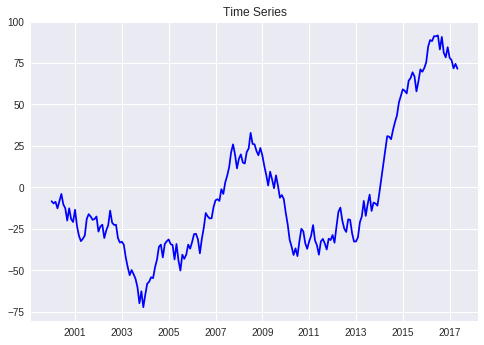

In [0]:
#%%
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import random

#%%
# Generate some data
random.seed(111)
rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
ts.plot(c='b', title='Time Series')


#%%
TS = np.array(ts,)
num_periods = 20
# 预测期数
f_horizon = 1
x_data = TS[:(len(TS)-(len(TS)%num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1: (len(TS) - (len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 20, 1)


#%%
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast) :]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-num_periods:].reshape(-1, 20, 1)
    return testX, testY
X_test, Y_test = test_data(TS, f_horizon, num_periods)



#%%
tf.reset_default_graph()

num_periods = 20
inputs = 1
hidden = 100
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.keras.layers.SimpleRNNCell(units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

learning_rate = 0.001
stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
traning_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

epochs = 1001
config = tf.ConfigProto(allow_soft_placement=True,log_device_placement=False)
with tf.Session(config=config) as sess:
    sess.run(init)
    for ep in range(epochs):
        sess.run(traning_op, feed_dict={X: x_batches, y: y_batches})
        if ep%100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print('\r epochs:', ep, 'MSE:', mse,end='',flush=True)
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)


Text(0.5,0,'Time Periods')

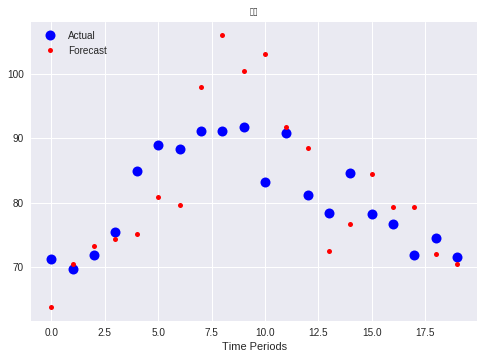

In [0]:
plt.title('预测')
plt.plot(pd.Series(np.ravel(Y_test)),'bo',markersize=10,label='Actual')
plt.plot(pd.Series(np.ravel(y_pred)),'r.',markersize=10,label='Forecast')
plt.legend(loc='upper left')

plt.xlabel('Time Periods')

## LSTM

Tensor("model_4/strided_slice:0", shape=(?, 10), dtype=float32)
 train steep: 9900 loss: 1.4575491e-05Tensor("model_5/strided_slice:0", shape=(?, 10), dtype=float32)

mean square error is :0.003888

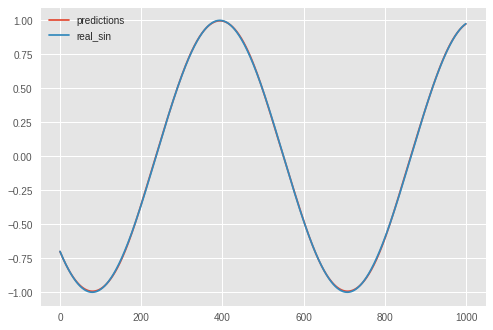

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

HIDDEN_SIZE = 10  # LSTM中隐藏节点的个数
NUM_LAYERS = 2  # LSTM的层数

TIMESTEPS = 10  # 训练序列长度
TRAINING_STEPS = 10000  # 训练轮数
BATCH_SIZE = 32

TRAINING_EXAMPLES = 1000  # 训练数据个数
TESTING_EXAMPLES = 1000  # 测试数据个数
SAMPLE_GAP = 0.01  # 采样间隔


def generate_data(seq):
    X = []
    y = []
    for i in range(len(seq) - TIMESTEPS):
        X.append([seq[i: i + TIMESTEPS]])
        y.append([seq[i + TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)


def lstm_mosdel(X, y, is_training):
    # 创建一个2层LSTM模型
    cell = tf.nn.rnn_cell.MultiRNNCell(
        [tf.nn.rnn_cell.LSTMCell(HIDDEN_SIZE) for _ in range(NUM_LAYERS)])
    # 将2层的LSTM结构连接成RNN网络并计算其前向传播结果
    outputs, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

    output = outputs[:, -1, :]

    # 在LSTM中增加一层全连接层并计算损失
    predictions = tf.contrib.layers.fully_connected(
        output, 1, activation_fn=None)

    # 在训练时计算损失和优化，测试时直接返回预测结果
    if not is_training:
        return predictions, None, None
    #计算MSE损失函数
    # loss = tf.reduce_mean(tf.square(y-predictions))
    loss = tf.losses.mean_squared_error(labels=y, predictions=predictions)

    # 创建模型优化器并得到优化步骤
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.train.get_global_step(), optimizer='Adagrad', learning_rate=0.1)

    return predictions, loss, train_op


def train(sess, train_X, train_y):
    ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
    ds = ds.repeat().shuffle(1000).batch(BATCH_SIZE)
    X, y = ds.make_one_shot_iterator().get_next()

    # 调用模型，得到预测结果，损失函数，和训练步骤
    with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
        predictions, loss, train_op = lstm_mosdel(X, y, True)

    sess.run(tf.global_variables_initializer())
    for i in range(TRAINING_STEPS):
        _, l = sess.run([train_op, loss])
        if i % 100 == 0:
            print('\r train steep:', i, 'loss:', l, end='', flush=True)


def run_eval(sess, test_X, test_y):
    # 将测试数据以数据集的方式提供给计算图
    ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
    ds = ds.batch(1)
    X, y = ds.make_one_shot_iterator().get_next()

    # 调用模型得到计算结果，这里并不需要输入真是的y值
    with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
        prediction, _, _ = lstm_mosdel(X, [0.0], False)

    predictions = []
    labels = []
    for i in range(TESTING_EXAMPLES):
        p, l = sess.run([prediction, y])
        predictions.append(p)
        labels.append(l)

    # 计算SMSE
    predictions = np.array(predictions).squeeze()
    labels = np.array(labels).squeeze()
    rmse = np.sqrt(((predictions - labels) ** 2).mean(axis=0))
    print('\nmean square error is :%f' % rmse, end='', flush=True)

    plt.figure()
    plt.plot(predictions, label='predictions')
    plt.plot(labels, label='real_sin')
    plt.legend()
    plt.show()


test_start = (TRAINING_EXAMPLES+TIMESTEPS)*SAMPLE_GAP
test_end = test_start + (TESTING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
train_X, train_y = generate_data(np.sin(np.linspace(
    0, test_start, TRAINING_EXAMPLES + TIMESTEPS, dtype=np.float32)))
test_X, test_y = generate_data(np.sin(np.linspace(
    test_start, test_end, TESTING_EXAMPLES + TIMESTEPS, dtype=np.float32)))
config = tf.ConfigProto(allow_soft_placement=True,log_device_placement=False,)
with tf.Session(config=config) as sess:
    train(sess, train_X, train_y)
    run_eval(sess, test_X, test_y)
